In [ ]:
m_step = 10e-5/t_unit

def captured_condition(t, y):
    if sum(map(lambda x : (x*cm_unit)**2, y[-3:])) > 1e-4:
        return -1
    if sum(map(lambda x : (velocity_unit*x)**2, y[-6:-3])) > 1:
        return -1
    return 1

def weak_cap_cond(v,p):
    if sum(map(lambda x : (x*cm_unit)**2, p)) > 2e-4:
        return -1
    if sum(map(lambda x : (velocity_unit*x)**2, v)) > 1.5:
        return -1
    return 1

def lost_condition(t, y):
    return y[-3]*cm_unit- 8

def backwards_lost(t, y):
    if (y[-3]*cm_unit < -10 and y[-6]*velocity_unit < 0):
        return -1
    return 1

def isCaptured(sol):
    # captured = -1
    # finalPosition = np.array([sol.r[i][-1] for i in range(3)])
    # finalVelocity = 0*np.array([sol.v[i][-1]*velocity_unit for i in range(3)])  # Fix capture cond
    # if (np.linalg.norm(finalPosition)**2 + np.linalg.norm(finalVelocity)**2 < 1e-2):
    #     #print('initial velocity: '+ str(sol.v[0][0]) +' captured')
    #     captured = 1 
    return weak_cap_cond(sol.v[:,-1],sol.r[:,-1])
    # return captured
    
def atomTrajectoryToMOT(v0, r0, eqn, angle = 0, classifier = isCaptured, tmax=5e-2/t_unit, max_step=m_step):
    print(v0*velocity_unit)
    eqn.set_initial_pop(np.concatenate([[1./36]*36,[0]*36]))
    if (isinstance(angle, numbers.Number)):
        eqn.set_initial_position_and_velocity(r0, np.array([v0*np.cos(angle),v0*np.sin(angle),0]))
    else:
        eqn.set_initial_position_and_velocity(r0, np.array([v0*np.cos(angle[0]),v0*np.sin(angle[0])*np.cos(angle[1]),v0*np.sin(angle[0])*np.sin(angle[1])]))
    eqn.evolve_motion([0., tmax], progress_bar=True,
                      max_step = max_step,
                      rtol=1e-3, atol=np.concatenate(([1e-3]*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit])),method="Radau", events=[captured_condition,lost_condition,backwards_lost])

    print(classifier(eqn.sol))
    return classifier(eqn.sol)

def findCaptureVelocity(r0,eqn):
    # print('a')
    if(atomTrajectoryToMOT(2/velocity_unit, r0, eqn)==-1):
        return 0
    # print('b')
    return bisect(atomTrajectoryToMOT,2/velocity_unit, 150/velocity_unit,
       args=(r0, eqn),
       xtol=1/velocity_unit, rtol=1e-3, full_output=False)

def captureVelocityForEq(ham, lasers, mfield):
    eq = pylcp.rateeq(lasers, mfield, ham, include_mag_forces=False)
    eq.set_initial_pop(np.concatenate([[1./36]*36,[0]*36]))
    return findCaptureVelocity(np.array([-5/cm_unit,0,0]), eq)

captured_condition.terminal = True
lost_condition.terminal = True
backwards_lost.terminal = True

In [ ]:
rateeq = pylcp.rateeq(MOT_Beams_nov1(-1*gammasim,0,0,0,s=1, wb=0.5/cm_unit, p=1), mag_field, hamiltonian,include_mag_forces=False)

r = np.linspace(-2/cm_unit, 2/cm_unit, 100)
v = np.linspace(-300/velocity_unit, 300/velocity_unit, 100)

R, V = np.meshgrid(r, v)
rateeq.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True)

angle = float(0)
vel = float(30)

vs = np.linspace(10,100,10)
# vs = [40]
sols = []
for vel in vs:
    rateeq.set_initial_position_and_velocity(np.array([-4/cm_unit, 0., 0.]),np.array([vel*np.cos(np.radians(angle))/velocity_unit, vel*np.sin(np.radians(angle))/velocity_unit, 0.]))
    rateeq.set_initial_pop(np.concatenate(([1./36]*36,[0]*36)))
    rateeq.evolve_motion([0., 5e-2/t_unit], progress_bar=True, max_step = 10e-5/t_unit, rtol=1e-3, atol=np.concatenate(([1e-3]*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit])),method="Radau", events=[captured_condition,lost_condition,backwards_lost])
    sols.append(rateeq.sol)


(-300.0, 300.0)

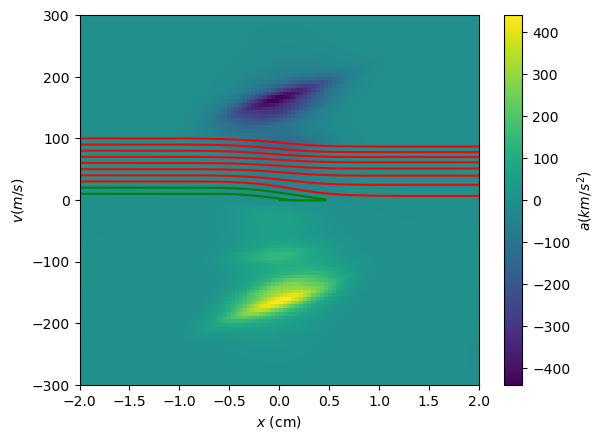

In [ ]:
Fprofile = rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27)
Fprofile[np.isnan(Fprofile)] = 0
fig, ax = plt.subplots(1, 1)
[ax.plot(sol.r[0]*cm_unit,sol.v[0]*velocity_unit,'g-' if isCaptured(sol) > 0 else 'r-') for sol in sols]
colormesh = ax.pcolormesh(R*cm_unit, V*velocity_unit, Fprofile, cmap = 'viridis')
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a(km/s^2)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v(m/s)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-2,2])
ax.set_ylim([-300,300])